Uses dgl==0.6.1

In [26]:
import pandas as pd
import numpy as np
from ogb.nodeproppred import DglNodePropPredDataset
import faiss
import torch
import matplotlib.pyplot as plt

In [2]:
dataset = DglNodePropPredDataset(name='ogbn-arxiv', 
                                 root='../../data/dataset_dgl/')

In [3]:
graph = dataset[0][0]

In [4]:
graph

Graph(num_nodes=169343, num_edges=1166243,
      ndata_schemes={'year': Scheme(shape=(1,), dtype=torch.int64), 'feat': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={})

In [5]:
graph.nodes()

tensor([     0,      1,      2,  ..., 169340, 169341, 169342])

In [28]:
output_emb_file = '../../ckpts/TransE_l2_ogbn-arxiv_2/ogbn-arxiv_TransE_l2_entity.npy'
output_rel_file = '../../ckpts/TransE_l2_ogbn-arxiv_2/ogbn-arxiv_TransE_l2_relation.npy'

In [29]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 10)

In [31]:
relations = np.load(output_rel_file)
relations.shape

(1, 10)

In [33]:
relations

array([[ 1.1064795, -7.251556 ,  4.845473 ,  1.5770537, -4.2837253,
         4.7235155,  7.316712 ,  5.2145567, -2.6030858,  5.591577 ]],
      dtype=float32)

In [34]:
np.linalg.norm(relations, axis=1)

array([15.466242], dtype=float32)

## L2 Distance

In [15]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [16]:
index.train(embeddings)
index.add(embeddings)

In [17]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7f23ac7390f0> >

In [18]:
index.ntotal

169343

### Check if there is a neighbor in the n closest embeddings

In [19]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [23]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [24]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

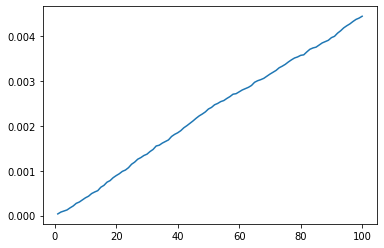

In [27]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

### Check if there is a neighbor in the n closest embeddings + relation

In [36]:
embeddings

array([[-0.76570725, -1.0899072 , -0.76050377, ..., -1.4019278 ,
         0.4569007 , -0.27539188],
       [-1.6489363 ,  1.1121172 ,  1.310688  , ...,  1.748477  ,
         0.26110145, -0.51407427],
       [ 0.36414617,  0.10182829,  0.07844748, ..., -1.2746279 ,
         1.2738042 , -1.533764  ],
       ...,
       [-1.4388547 , -1.3355291 ,  1.2198706 , ..., -1.6577222 ,
        -1.3725159 , -1.7848283 ],
       [ 1.365776  ,  1.7486248 ,  0.05584155, ...,  1.292088  ,
        -1.7295866 , -1.3166554 ],
       [-1.7966888 , -1.5278947 ,  1.6159921 , ...,  1.419532  ,
        -1.118486  , -1.2830914 ]], dtype=float32)

In [37]:
embeddings + relations

array([[ 0.34077227, -8.341463  ,  4.084969  , ...,  3.8126287 ,
        -2.1461852 ,  5.316185  ],
       [-0.54245675, -6.1394386 ,  6.156161  , ...,  6.9630337 ,
        -2.3419843 ,  5.0775027 ],
       [ 1.4706256 , -7.149728  ,  4.92392   , ...,  3.9399288 ,
        -1.3292816 ,  4.057813  ],
       ...,
       [-0.33237517, -8.587085  ,  6.0653434 , ...,  3.5568345 ,
        -3.9756017 ,  3.8067489 ],
       [ 2.4722555 , -5.502931  ,  4.9013143 , ...,  6.5066447 ,
        -4.332672  ,  4.2749214 ],
       [-0.69020927, -8.77945   ,  6.461465  , ...,  6.6340885 ,
        -3.721572  ,  4.3084855 ]], dtype=float32)

In [39]:
max_k = 100
distances, indices = index.search(embeddings + relations, max_k + 1)

In [44]:
distances

array([[167.81145, 168.80052, 169.03299, ..., 184.6338 , 184.74643,
        184.89517],
       [165.2212 , 166.01796, 166.41588, ..., 181.02853, 181.11739,
        181.30942],
       [142.892  , 143.8693 , 144.85204, ..., 159.40248, 159.42416,
        159.4415 ],
       ...,
       [146.30267, 149.74539, 150.56367, ..., 162.30966, 162.32846,
        162.51013],
       [151.4126 , 153.72946, 153.82477, ..., 171.31299, 171.33441,
        171.57901],
       [216.8711 , 217.41904, 219.03085, ..., 233.78659, 233.84674,
        233.90549]], dtype=float32)

In [43]:
indices

array([[138938,  89783,  93423, ...,  87354, 104676,  22488],
       [ 28974, 112362, 138938, ...,  19136,  90147, 112649],
       [143578, 138938,  93423, ...,  28974,   9823, 104676],
       ...,
       [ 89783, 151864, 132347, ..., 160271,  84631,  31870],
       [112362, 138938, 128793, ...,  61572, 156084, 149805],
       [151864,  28974, 138938, ...,  20838,  87895, 160271]])

In [40]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [41]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

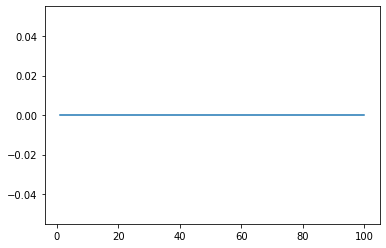

In [42]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)